# Botnet Logistic Regression Classifier

Centralised version of readFile, normalize, train and accuracy functions. The algorithm converges during training, the cost value decreases asymptotically at each iteration. The final reported accuracy of 93.02% suggests that the model is performing well on the given dataset.

### Preprocessing

The `readFile` function reads the data, parses each line by splitting it on commas, converts each value to a float, and then aggregates the data into a NumPy array. This array contains both features and labels (last column) of each data entry.

In [1]:
import os
import numpy as np

def readFile(filename):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    data = []
    with open(parent_directory + "/" + filename, "r") as file:
        for line in file:
            # Split the line into columns, convert each to float, and add to data list
            # Note: The last column (label) is also converted to float for consistency in the array
            cols = [float(x) for x in line.strip().split(",")]
            data.append(cols)

    data_array = np.array(data)

    return data_array

### Normalizing

The `normalize` function standardizes the feature columns of a NumPy array to have a mean of 0 and a standard deviation of 1, avoids division by zero for constant features, and then recombines these normalized features with their original labels.

In [2]:
def normalize(np_Xy):

    # Extracting features (X) and labels (y) from the input array
    X = np_Xy[:, :-1]
    y = np_Xy[:, -1].reshape(-1, 1)

    # Computing mean and standard deviation
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)

    # Avoid division by zero
    std_dev[std_dev == 0] = 1

    # Compute normalized features and stack the labels
    X_norm = (X - mean) / std_dev
    X_norm = np.hstack((X_norm, y))

    return X_norm

### Training

The `train` function implements logistic regression using gradient descent and L2 regularization. It extracts features and labels from the NumPy array, initializes weights and bias randomly, then iteratively updates these parameters based on the computed gradients of a cost function that includes logistic loss and regularization. The function outputs the optimized weights and bias after the specified number of iterations.

In [7]:
def train(np_Xy, iterations, learning_rate, lambda_reg):

    # Extracting features (X) and labels (y) from the input array
    X = np.array([example[:-1] for example in np_Xy])  # Extract features
    y = np.array([example[-1] for example in np_Xy])   # Extract labels

    # Number of examples and features
    m, k = X.shape

    np.random.seed(0) # Added for reproducibility
    # Initializing weights and bias with random values
    w = np.random.rand(k)
    b = np.random.rand()

    cost_history = []

    for i in range(iterations):

        # Compute predictions
        z = np.dot(X, w) + b
        y_hat = 1 / (1 + np.exp(-z))  # Applying the sigmoid function

        # Cost function with L2 regularization
        cost = (-1/m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        cost += (lambda_reg / (2*k)) * np.sum(w**2)
        cost_history.append(cost)

        print(f"Iteration {i}, Cost: {cost}")

        # Gradient calculation
        dw = (1/m) * np.dot(X.T, (y_hat - y)) + (lambda_reg/k) * w
        db = (1/m) * np.sum(y_hat - y)

        # Gradient calculation with np.sum and for loop
        # dw = np.zeros(k)
        # for j in range(k):
        #    dw[j] = (1/m) * np.sum((y_hat - y) * X[:, j]) + (lambda_reg/k) * w[j]
        # db = (1/m) * np.sum(y_hat - y)

        # Update weights and bias
        w -= learning_rate * dw
        b -= learning_rate * db

    return w, b, cost_history

### Predict

The `predict` function calculates the linear combination of features and weights, adds bias, applies the sigmoid function to derive a probability, and then classifies the input as either class 0 or 1 based on this probability (threshold at 0.5). This function is used for making predictions on individual data examples using trained logistic regression parameters.

In [8]:
def predict(w, b, X):
    # Compute the linear combination of the weights and the example
    z = 0
    for i in range(len(w)):
        z += w[i] * X[i]
    z+=b
    # Apply the sigmoid function to get the probability
    p = 1 / (1 + np.exp(-z))
    # Predict the class label (0 or 1) based on the probability
    if p >= 0.5:
        return 1
    else:
        return 0

### Accuracy

The `accuracy` function evaluates the accuracy of the logistic regression model by comparing its predictions with actual labels in the provided dataset. It iterates over each data point, uses the `predict` function with the model's weights and bias, and counts the number of correctly classified examples to calculate the overall accuracy.

In [9]:
def accuracy (w, b, np_Xy):
    correctly_classified = 0;
    for element in np_Xy:
        if(predict(w,b,element[0:11]) == element[11]):
            correctly_classified += 1

    accuracy = correctly_classified/np_Xy.shape[0]
    return accuracy

### Testing

The following code snippet is used for testing the whole system:

In [10]:
iterations = 10
learning_rate = 1.5
lamda_reg = 0.05

# read data
data = readFile("data/botnet_tot_syn_l.csv")
# standardize
data = normalize(data)
# train
weights, bias, cost_values = train(data, iterations, learning_rate, lamda_reg)
# accuracy
accuracy = accuracy(weights, bias, data)
print("Accuracy:", accuracy)

Iteration 0, Cost: 1.5106185661372558
Iteration 1, Cost: 0.746530784633892
Iteration 2, Cost: 0.44929634449347844
Iteration 3, Cost: 0.34179443441940904
Iteration 4, Cost: 0.2939229065429816
Iteration 5, Cost: 0.2680999330032723
Iteration 6, Cost: 0.25221536558937524
Iteration 7, Cost: 0.24154694081042147
Iteration 8, Cost: 0.23393022317799456
Iteration 9, Cost: 0.2282448669811169
Accuracy: 0.930215


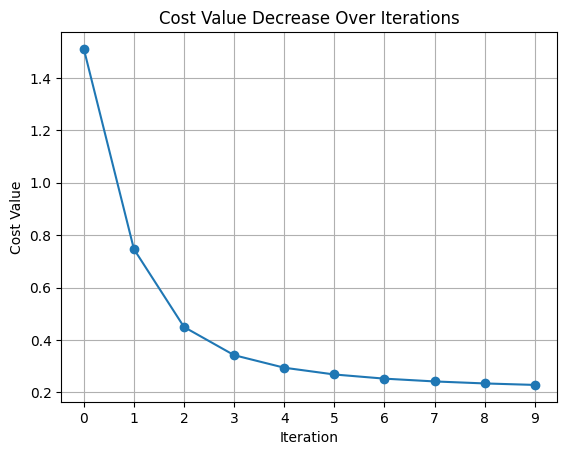

In [13]:
import matplotlib.pyplot as plt

# Plotting the cost values
plt.plot(range(10), cost_values, marker='o')
plt.title('Cost Value Decrease Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Cost Value')
plt.xticks(range(10))
plt.grid(True)
plt.show()